# Bias-Variance decomposition

#### Concept
To illustrate the concept of the bias-variance decomposition of the generalization error, we will first try to model the following function:
\begin{equation}
f(x)=sin(\pi x)
\end{equation}

From the first lecture, we assume that the observations $y$ follow the following distribution:
\begin{equation}
y=f(x) + \mathcal{N}(0,\sigma^2)
\end{equation}

Let us generate some data that meet our assumptions:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn import linear_model
import math
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

np.random.seed(5)

In [163]:
N = 10; 
x = 2*(np.random.rand(N, 1) -0.5)
xGrid = np.linspace(-1,1,100)

In [164]:
def f(x):
    y = 2*np.sin(math.pi*x)
    return y

In [ ]:
f_x = f(xGrid)
plt.plot(xGrid,f_x)

sigma = 0.2
y = f(x) + sigma*np.random.randn(len(x),1)

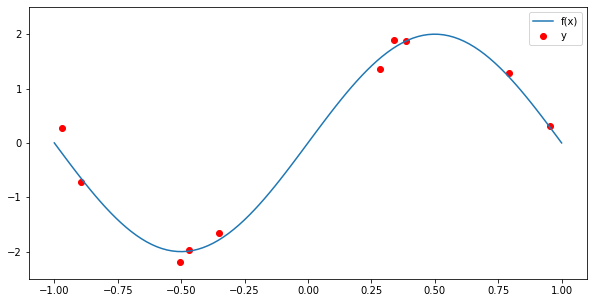

In [167]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x,y, c='r')
plt.legend(['f(x)', 'y'])
plt.ylim(-2.5,2.5)
plt.show()

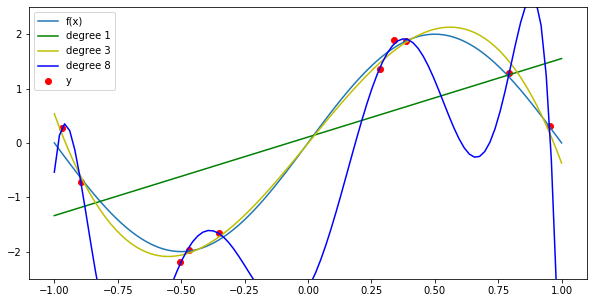

In [168]:
degree = [1,3,8]
plt.plot(xGrid,f_x)
xGrid = xGrid.reshape(len(xGrid),1)
plt.scatter(x,y, c='r')
colors=['g','y', 'b']
count = 0
#xGrid = xGrid.reshape(len(xGrid),1)
for a_degree in degree:
    poly = PolynomialFeatures(degree=a_degree)
    x_ = poly.fit_transform(x)
    predict_ = poly.fit_transform(xGrid)
    clf = linear_model.LinearRegression()
    clf.fit(x_, y)
    y_hat = clf.predict(predict_)
    plt.plot(xGrid,y_hat, color=colors[count], label='degree: ' + str(a_degree))
    count += 1
plt.legend(['f(x)'] + ['degree ' + str(x) for x in degree] + ['y'] )
plt.ylim(-2.5,2.5)
plt.show()

To get an idea of how each of the estimators above performs in general we can repeat the model fitting procedure for many data sets.

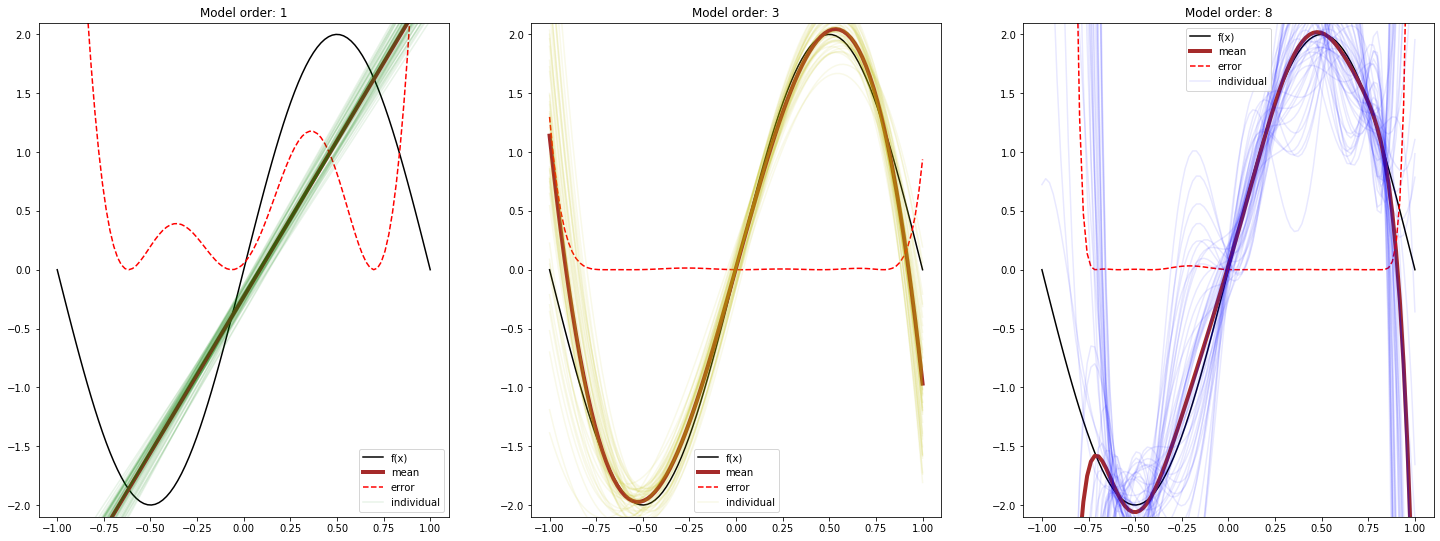

In [7]:
#FIT MODELS TO K INDEPENDENT DATASETS
plt.rcParams['figure.figsize'] = [25, 20]
K = 50;
empty=[np.zeros((K,len(xGrid))) for i in range(0,len(degree))] 
simulation= dict(zip(degree,empty))
for iS in range(0,K):
    ySim = f(x) + sigma*np.random.randn(len(x),1)
    for a_degree in degree:
        poly = PolynomialFeatures(degree=a_degree)
        x_ = poly.fit_transform(x)
        predict_ = poly.fit_transform(xGrid)
        clf = linear_model.LinearRegression()
        clf.fit(x_, ySim)
        y_hat = clf.predict(predict_)
        simulation[a_degree][iS,:]=np.squeeze(y_hat) 

for count, a_degree in enumerate(degree):
    ax1 = plt.subplot(231+count)
    ax1.plot(xGrid,f_x, color='black')
    ax1.plot(xGrid,np.mean(simulation[a_degree],0), color='brown',linewidth=4, label='mean')
    
    squared_error = (np.mean(simulation[a_degree],0) - np.squeeze(f_x))**2
    ax1.plot(xGrid,squared_error, color='red', linestyle='--')
    
    for iS in range(0,K):
        ax1.plot(xGrid,simulation[a_degree][iS,:],color=colors[count], alpha=0.09)
    ax1.legend(['f(x)', 'mean', 'error', 'individual'])
    ax1.set_title('Model order: ' + str(a_degree))

    plt.ylim(-2.1,2.1)
plt.show()

**Question**: What can you say about the variance of each model? their bias? is any model overfitting? underfitting?

#### Generalization error decomposition
Now let us do another set of experiments

In [52]:
N = 25 #Observations per dataset
K = 100 # number of datasets 
sigma = .5 #noise std_dev
n_train = math.ceil(N*.9); # size of training set
poly_order = 12 #max model complexity

In [155]:
x = np.linspace(-1,1,N)
x = x[np.random.permutation(N)]
x = x.reshape(N,1)

x_train = x[0:n_train]
x_test = x[n_train:] 
y_truth=f(x_test)
degrees = [i for i in range(1,poly_order+1)]

simulation_test=dict(zip(degrees,[np.zeros((K,(N-n_train))) for i in range(0,poly_order)]))
simulation_train=dict(zip(degrees,[np.zeros((K,(n_train))) for i in range(0,poly_order)] ))

error_test=dict(zip(degrees,[(K)*[0] for i in range(0,poly_order)]))
error_train=dict(zip(degrees,[(K)*[0] for i in range(0,poly_order)]))
   
for iS in range(0,K):
    y_sim = f(x) + sigma*np.random.randn(len(x),1)
    
    #training set
    y_train = y_sim[0:n_train]
 
    #test set
    y_test = y_sim[n_train:]
    
   # print(iS, y_test)
    for order in range(1,poly_order+1):
        poly = PolynomialFeatures(degree=order)
        x_ = poly.fit_transform(x_train)
        predict_ = poly.fit_transform(x_test)
        clf = linear_model.LinearRegression()
        clf.fit(x_, y_train)
        y_hat_test = clf.predict(predict_)
        y_hat_train = clf.predict(x_)

        #Store predictions
        simulation_test[order][iS,:]=np.squeeze(y_hat_test) 
        simulation_train[order][iS,:]=np.squeeze(y_hat_train) 

        #Mean squared error
        error_test[order][iS] = np.mean((np.squeeze(y_hat_test) - np.squeeze(y_test))**2)
        error_train[order][iS] = np.mean((np.squeeze(y_hat_train) - np.squeeze(y_train))**2)


train_error = [np.mean(error_train[order]) for order in range(1,poly_order+1)]
test_error = [np.mean(error_test[order]) for order in range(1,poly_order+1)]
variance = [np.mean(np.var(simulation_test[order],0)) for order in range(1,poly_order+1)] 
bias_sq = [np.mean((np.mean(simulation_test[order],0) - y_truth)**2) for order in range(1,poly_order+1)]

best_model = np.argmin(test_error)

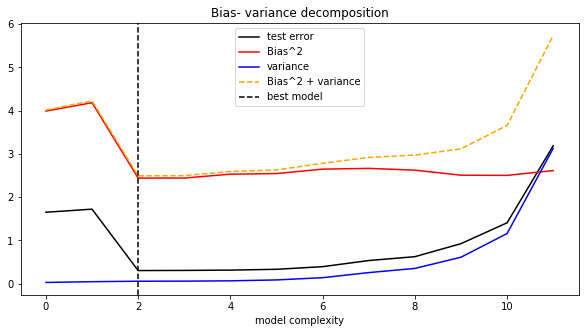

In [169]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(test_error, color='k')
plt.plot(bias_sq, color='r')
plt.plot(variance, color='b')

plt.plot(np.array(bias_sq) + np.array(variance), color='orange', linestyle='--')
plt.axvline(x=best_model, linestyle='--', color='k')

plt.legend(['test error', 'Bias^2', 'variance', 'Bias^2 + variance', 'best model'])
plt.xlabel('model complexity')
plt.title('Bias- variance decomposition')
plt.show()

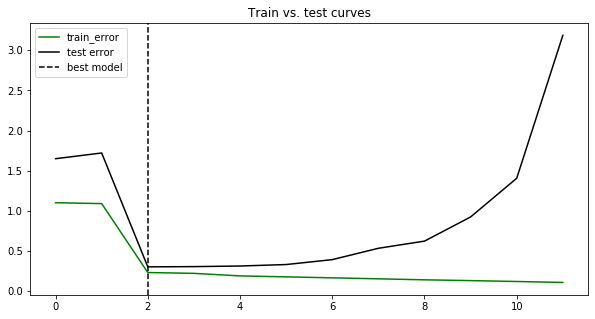

In [162]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(train_error,color='g')
plt.plot(test_error,color='k')
plt.axvline(x=best_model, linestyle='--', color='k')

plt.legend(['train_error', 'test error', 'best model'])
plt.title('Train vs. test curves')
plt.show()